### Imports

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, Dropout
from tensorflow.keras.initializers import GlorotUniform
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, auc

### Download & Load the dataset

In [ ]:
# URL = 'https://zenodo.org/record/5208230/files/pathmnist.npz?download=1'
# path = tf.keras.utils.get_file('pathmnist.npz', origin=URL)

In [21]:
# load the dataset
data = np.load('pathmnist.npz')

# split the dataset to train, validation, test sets. 89,996 / 10,004 / 7,180
x_train = data['train_images']
y_train = data['train_labels']
x_val = data['val_images']
y_val = data['val_labels']
x_test = data['test_images']
y_test = data['test_labels']

# get the number of classes in dataset
num_classes = len(np.unique(y_train))
print("num classes:", num_classes)

# normalize the values of data
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

# convert the labels to a one_hot_encoded vector
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)

num classes: 9


#### A function to visualize 100 images of the training set

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


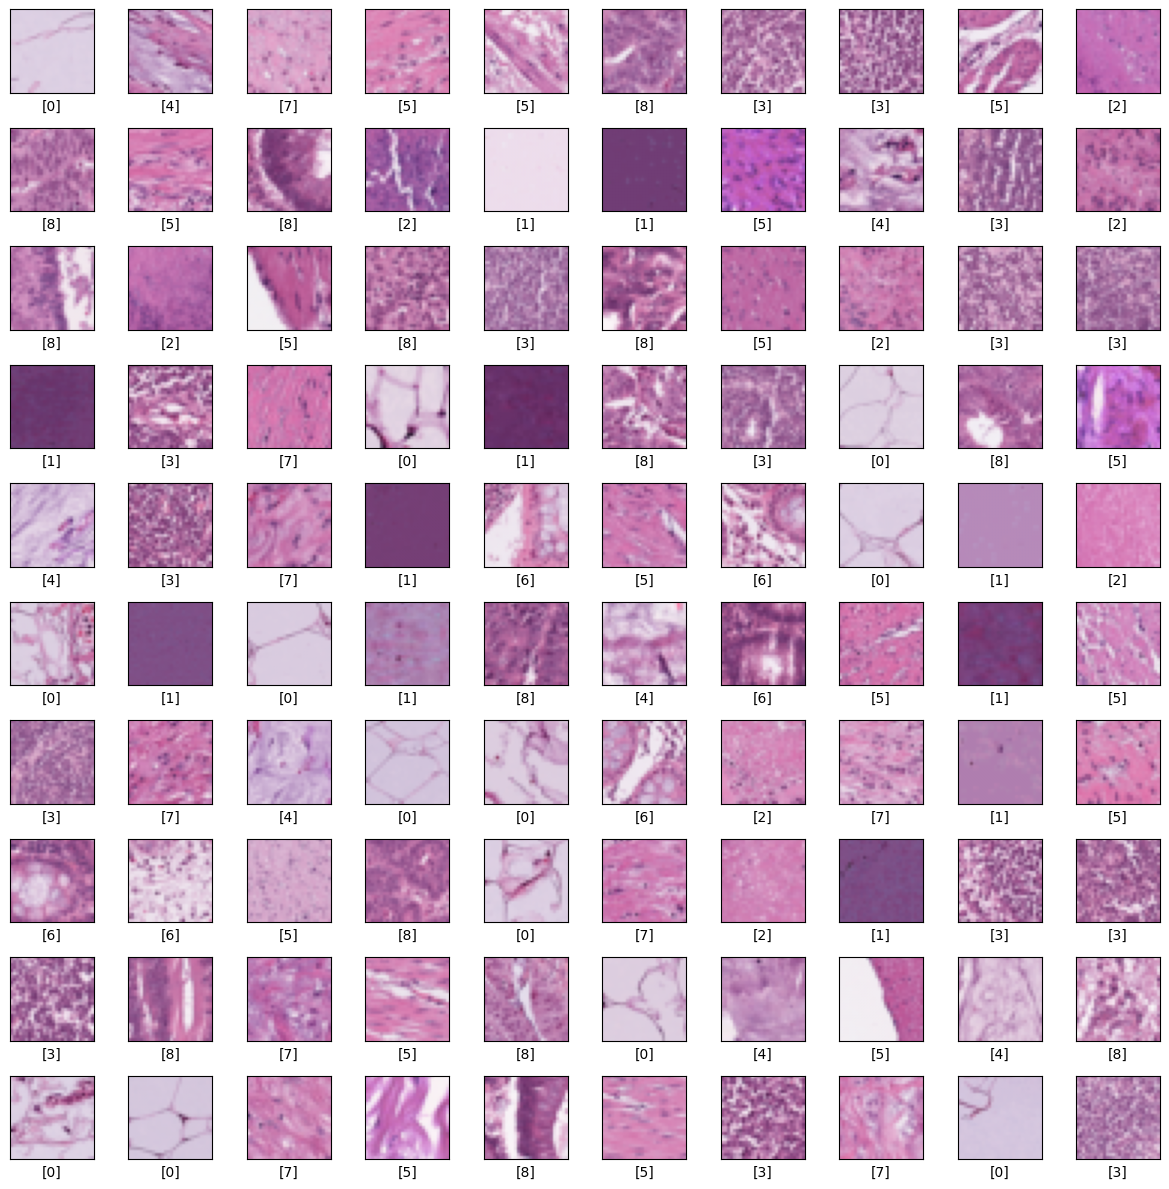

In [5]:
def visualize_images(images, labels, num_images=100, grid_size=(10, 10)):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='gray')
        plt.xlabel(labels[i])
    plt.tight_layout()
    plt.show()

# Visualize the first 100 training images and their labels
visualize_images(x_train, y_train, num_images=100, grid_size=(10, 10))

## Create the model

* <b>Convolutional layers (Conv2D)</b> apply filters (kernels) to the input data to detect features such as edges, textures, and patterns. They perform convolution operations that result in feature maps, which highlight the presence of specific features at various spatial locations in the input image. By using multiple convolutional layers, the network can learn to identify complex patterns and hierarchical features, improving its ability to recognize objects and details within images.

* <b>MaxPooling layers</b> reduce the spatial dimensions (width and height) of the input feature maps by selecting the maximum value from each pooling window. This operation helps to downsample the feature maps, reducing the number of parameters and computational load, and makes the model more robust to spatial variations and noise. MaxPooling also helps to retain the most significant features detected by the convolutional layers.

* The <b>Flatten layer</b> converts the 2D matrix of feature maps from the convolutional and pooling layers into a 1D vector. This transformation allows the resulting features to be fed into fully connected (dense) layers, enabling the model to learn and classify based on the combined features extracted from the previous layers. Flattening is a necessary step before connecting to dense layers for classification or regression tasks.

* <b>Dense layers</b>, also known as fully connected layers, are layers where each neuron is connected to every neuron in the previous layer. These layers process the flattened input by learning the complex relationships between the features and the output classes. Dense layers are crucial for combining features learned by convolutional layers to make final predictions. They are often used towards the end of the network in classification tasks, outputting probabilities for each class when using activation functions like softmax.

* <b>Dropout</b> is a regularization technique used in neural networks to prevent overfitting. It works by randomly "dropping out" (setting to zero) a fraction of neurons during training, forcing the network to learn redundant representations and improving its generalization capabilities. This technique helps ensure that the model does not rely too heavily on any single neuron and improves its ability to perform well on unseen data.


* Relu activation function:</br>
  <img src="image.png" alt="Image" width="600" height="300"></br>

  ReLU (Rectified Linear Unit) is an activation function commonly used in neural networks. It outputs the input directly if it is positive; otherwise, it outputs zero, introducing non-linearity and helping the network learn complex patterns.

* softmax activation function:</br>
  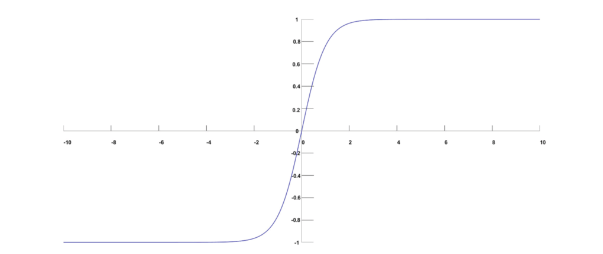</br>
  Softmax is an activation function used in the output layer of classification models. It converts raw scores (logits) into probabilities by exponentiating each score and normalizing by the sum of all exponentiated scores, ensuring the outputs are in the range (0, 1) and sum to 1.

* Xavier initializer: also known as Glorot initialization, sets the weights of a neural network to values that maintain the variance of the outputs at the same scale as the inputs across layers. This helps to prevent the vanishing and exploding gradient problems during training.


At the end, we wanted a model like VGG16. I have explained the architecture of the model in the document.

In [22]:
def create_model(input_shape=(28, 28, 3), num_classes=9):
    """
    Create a CNN model with the specified input shape and number of output classes.

    Parameters:
    input_shape (tuple): Shape of the input images, default is (28, 28, 3).
    num_classes (int): Number of output classes, default is 9.

    Returns:
    model (Sequential): The constructed Keras Sequential model.
    """
    
    # we want to create a basic sequential model that each layer is connected to next layer.
    model = Sequential()

    # Block 1: First set of convolutional and max pooling layers
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer=GlorotUniform(), input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer=GlorotUniform()))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2: Second set of convolutional and max pooling layers
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=GlorotUniform()))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=GlorotUniform()))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3: Third set of convolutional and max pooling layers
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=GlorotUniform()))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=GlorotUniform()))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4: Fourth set of convolutional and max pooling layers
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer=GlorotUniform()))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer=GlorotUniform()))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Fully connected layers: Flattening and dense layers for classification
    model.add(Flatten()) # Flatten the input
    model.add(Dense(512, activation='relu', kernel_initializer=GlorotUniform())) # First fully connected layer
    model.add(Dropout(0.5)) # Dropout for regularization
    model.add(Dense(512, activation='relu', kernel_initializer=GlorotUniform())) # Second fully connected layer
    model.add(Dropout(0.5)) # Dropout for regularization
    model.add(Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform())) # Output layer with softmax activation

    return model

# Create the model
model = create_model()

### Compile the model

* Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric.
   1. adam: Adaptive moment estimation optimizer that adjusts learning rates during training.
   2. categorical_crossentropy: Loss function used for multi-class classification problems.
   3. metrics=['accuracy']: Metric to evaluate the model's performance during training and evaluation.


In [23]:
# compile the model
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [18]:
# get some information about the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                

### Train the model

* Train the model using the training data and evaluate on validation data.
  1. x_train, y_train_one_hot: Training features and their one-hot encoded labels.
  2. batch_size=32: Number of samples processed before updating the model.
  3. epochs=20: Number of times the entire dataset is passed through the model during training.
  4. validation_data=(x_val, y_val_one_hot): Data used for evaluating the model's performance after each epoch.
   
 The `history` object will store training metrics such as loss and accuracy for each epoch.

In [24]:
# train the model
history = model.fit(
    x_train, y_train_one_hot,
    batch_size=32,
    epochs=16,
    validation_data=(x_val, y_val_one_hot)
)

Epoch 1/16
2813/2813 [==============================] - 95s 33ms/step - loss: 1.3688 - accuracy: 0.4832 - val_loss: 1.0447 - val_accuracy: 0.6031
Epoch 2/16
2813/2813 [==============================] - 91s 32ms/step - loss: 0.8235 - accuracy: 0.7030 - val_loss: 0.7964 - val_accuracy: 0.7081
Epoch 3/16
2813/2813 [==============================] - 91s 32ms/step - loss: 0.6841 - accuracy: 0.7593 - val_loss: 0.6821 - val_accuracy: 0.7495
Epoch 4/16
2813/2813 [==============================] - 91s 32ms/step - loss: 0.5890 - accuracy: 0.7951 - val_loss: 0.4703 - val_accuracy: 0.8331
Epoch 5/16
2813/2813 [==============================] - 90s 32ms/step - loss: 0.5251 - accuracy: 0.8178 - val_loss: 0.4648 - val_accuracy: 0.8369
Epoch 6/16
2813/2813 [==============================] - 91s 32ms/step - loss: 0.4852 - accuracy: 0.8319 - val_loss: 0.4658 - val_accuracy: 0.8369
Epoch 7/16
2813/2813 [==============================] - 92s 33ms/step - loss: 0.4437 - accuracy: 0.8470 - val_loss: 0.3850 -

### Test the model

${precision} = \frac{TP}{\text{TP+FP}}$ </br></br>
${recall} = \frac{TP}{\text{TP+FN}}$ </br></br>
${F1-Score} = \frac{2*precision*recall}{\text{precision+recall}}$

In [25]:
# Evaluate the model's performance on the test dataset.
test_loss, test_acc = model.evaluate(x_test, y_test_one_hot)
print(f"Test accuracy: {test_acc*100:.2f}")

# Get predictions
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# calculate precision, recall, f1_score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Print classification report
print(classification_report(y_true, y_pred))

225/225 [==============================] - 2s 11ms/step - loss: 0.5804 - accuracy: 0.8426
Test accuracy: 84.26
225/225 [==============================] - 2s 10ms/step
Precision: 0.86
Recall: 0.84
F1 Score: 0.84
              precision    recall  f1-score   support

           0       0.87      0.99      0.93      1338
           1       0.90      1.00      0.95       847
           2       0.43      0.75      0.55       339
           3       0.90      0.98      0.94       634
           4       0.96      0.72      0.82      1035
           5       0.75      0.74      0.75       592
           6       0.90      0.82      0.86       741
           7       0.58      0.48      0.52       421
           8       0.95      0.82      0.88      1233

    accuracy                           0.84      7180
   macro avg       0.81      0.81      0.80      7180
weighted avg       0.86      0.84      0.84      7180



### Plot the results

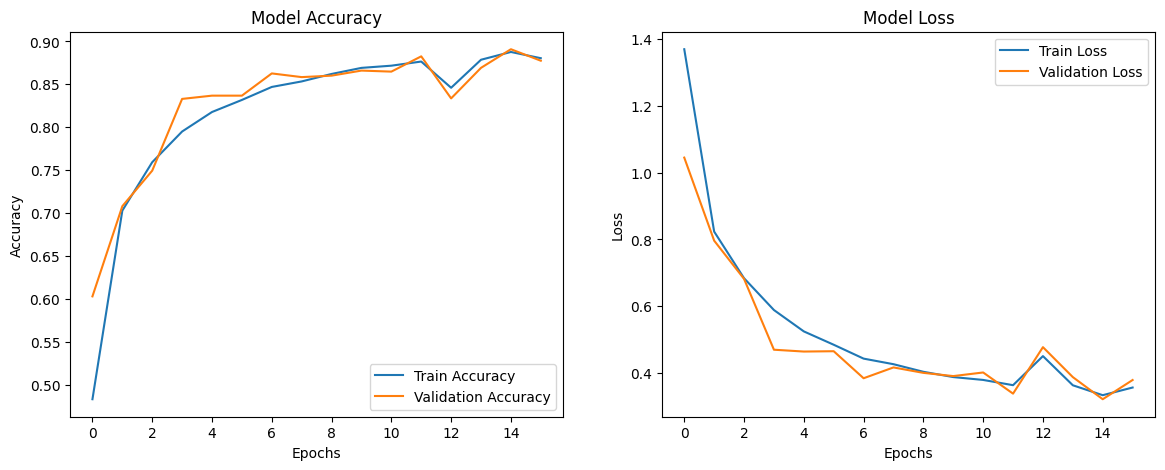

In [26]:
def plot_acc_loss():
    """
    Plots the accuracy and loss diagrams during model training.
    
    This function creates two subplots:
    - The first subplot shows the training and validation accuracy over epochs.
    - The second subplot shows the training and validation loss over epochs.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend() # Add a legend to differentiate between train and validation accuracy

    # Plot loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend() # Add a legend to differentiate between train and validation loss
    
plot_acc_loss()

### Plot ROC curve

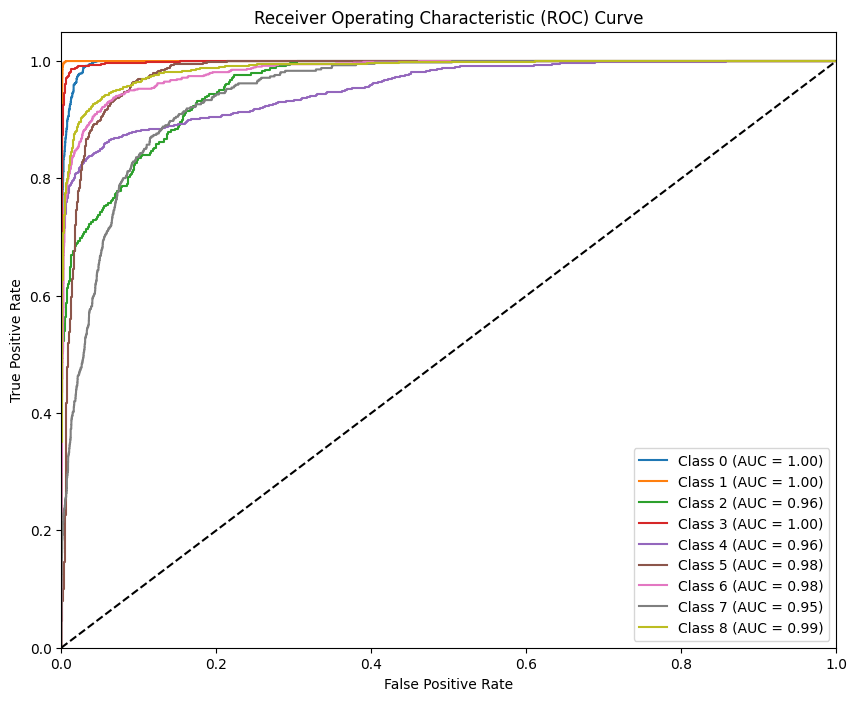

In [27]:
def plot_roc_curve():
    # Plot ROC curve for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    
plot_roc_curve()